In [74]:
# Pour le colab
# !pip install gym==0.24 pygame numpy tqdm --quiet

In [75]:
import sys 
import os

import numpy as np
import pandas as pd
import gym

from tool_functions import initialize_q_table, evaluate_agent

from qlearning import q_learning
from sarsa import sarsa
from every_visit_q_mc import every_visit_mc

### Création et étude de l'environnement

We're going to train our Q-Learning agent **to navigate from the starting state (S) to the goal state (G) by walking only on frozen tiles (F) and avoid holes (H)**.

We can have two sizes of environment:

- `map_name="4x4"`: a 4x4 grid version
- `map_name="8x8"`: a 8x8 grid version


The environment has two modes:

- `is_slippery=False`: The agent always moves **in the intended direction** due to the non-slippery nature of the frozen lake (deterministic).
- `is_slippery=True`: The agent **may not always move in the intended direction** due to the slippery nature of the frozen lake (stochastic).


Si l'agent **atteint l'objectif** il reçoit une **récompense de 1**, s'il ne **l'atteint pas** (se déplace seulement) il reçoit **0** et s'il **tombe dans un trou** il reçoit également **0**.

In [76]:
# 1er cas : carte 4x4 sans glisse 
env = gym.make(
    'FrozenLake-v1',
    map_name="4x4", 
    is_slippery=False
)

state_space = env.observation_space.n
print("Il y a", state_space, "états possibles")

action_space = env.action_space.n
print("Il y a", action_space, "actions possibles")

# Pour l'évaluation des modèles
eval_env = gym.make(
    'FrozenLake-v1',
    map_name="4x4", 
    is_slippery=False
)

Il y a 16 états possibles
Il y a 4 actions possibles


We see with `Observation Space Shape Discrete(16)` that the observation is an integer representing the **agent’s current position as current_row * nrows + current_col (where both the row and col start at 0)**. 

For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map. **For example, the 4x4 map has 16 possible observations.**


For instance, this is what state = 0 looks like:

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit2/frozenlake.png" alt="FrozenLake">

In [77]:
# Hyperparamètres partagés par tous les modèles la comparison des modèles

# Entraînement
n_training_episodes = 5000  # Nombre d'épisdoes d'entrainement
max_steps = 500             # Nombre maximla d'itérations pour un épisode
learning_rate = 0.7         # Taux d'apprentissage (poids accordé au passé pour la mise à jour de la table de Q)
gamma = 0.99

# Exploration 
max_epsilon = 0.8       
min_epsilon = 0.1            
decay_rate = 0.001          # Décroissance exponentielle pour le epsillon considéré par Q de taux decay_rate

# Pour l'affichages des résultats 
res = pd.DataFrame()
smooth = 100 # Lissage des courbes

### Performances d'un "Estimateur MC - Chaque-Passage" 

In [78]:
# Obligé de réduire max_steps pour que l'algorithme converge en temps raisonnable 
mc_table = initialize_q_table(state_space, action_space)

mc_table, mc_rewards = every_visit_mc(
    n_training_episodes=n_training_episodes,
    max_steps=max_steps,
    min_epsilon=0.005,
    max_epsilon=0.9,
    decay_rate=decay_rate,
    learning_rate=learning_rate,
    gamma=gamma,
    env=env,
    Qtable=mc_table
)

100%|██████████| 5000/5000 [00:00<00:00, 7140.87it/s]


In [79]:
mc_rewards = pd.Series(mc_rewards)
mc_rewards = mc_rewards.rolling(smooth, center=True).mean()
res['IMC-FL'] = mc_rewards

In [80]:
# Lors de l'évaluation plus d'epsillon
evaluate_agent(eval_env, max_steps=100, n_eval_episodes=100, Q=mc_table)

100%|██████████| 100/100 [00:00<00:00, 3847.17it/s]


(1.0, 0.0)

### Performances de Sarsa

In [81]:
sarsa_table = initialize_q_table(state_space, action_space)

sarsa_table, rewards = sarsa(
    n_training_episodes=n_training_episodes,
    max_steps=max_steps,
    min_epsilon=0.005,
    max_epsilon=0.9,
    decay_rate=decay_rate,
    learning_rate=learning_rate,
    gamma=gamma,
    env=env,
    Qtable=sarsa_table
)

100%|██████████| 5000/5000 [00:01<00:00, 3175.44it/s]


In [82]:
sarsa_rewards = pd.Series(rewards)
sarsa_rewards = sarsa_rewards.rolling(smooth, center=True).mean()
res['sarsa-FL'] = sarsa_rewards

In [83]:
# Lors de l'évaluation plus d'epsillon
evaluate_agent(eval_env, max_steps=100, n_eval_episodes=100, Q=sarsa_table)

100%|██████████| 100/100 [00:00<00:00, 4943.20it/s]


(1.0, 0.0)

### Performances de Q-learning

In [84]:
qlearning_table = initialize_q_table(state_space, action_space)

qlearning_table, rewards = q_learning(
    n_training_episodes=n_training_episodes,
    max_steps=max_steps,
    min_epsilon=0.005,
    max_epsilon=0.9,
    decay_rate=decay_rate,
    learning_rate=learning_rate,
    gamma=gamma,
    env=env,
    Qtable=qlearning_table
)

100%|██████████| 5000/5000 [00:00<00:00, 5386.90it/s]


In [85]:
qlearning_rewards = pd.Series(rewards)
qlearning_rewards = qlearning_rewards.rolling(smooth, center=True).mean()
res['qlearning-FL'] = qlearning_rewards

In [86]:
# Lors de l'évaluation plus d'epsillon
evaluate_agent(eval_env, max_steps=100, n_eval_episodes=100, Q=qlearning_table)

100%|██████████| 100/100 [00:00<00:00, 4567.07it/s]


(1.0, 0.0)

### Illustrations

In [87]:
import matplotlib.pyplot as plt

<AxesSubplot: >

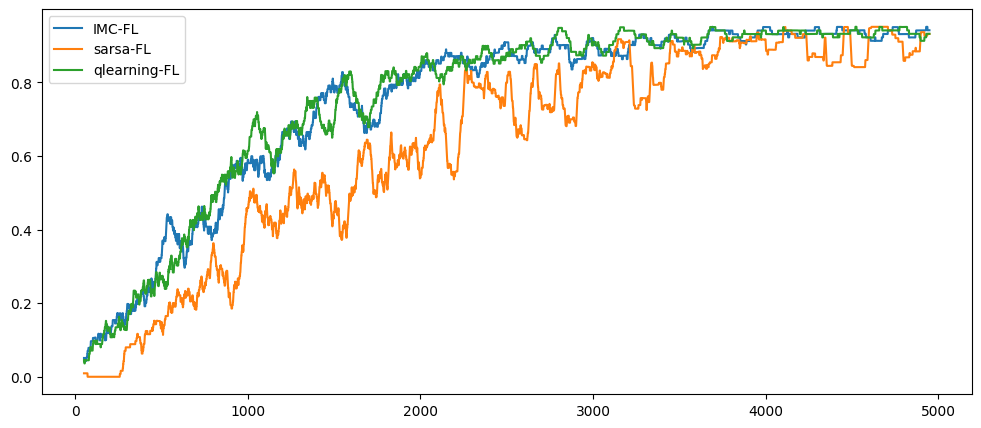

In [88]:
fig, ax = plt.subplots(figsize=(12, 5))
res.plot(ax=ax)